## NLP_GoingDeeper | P-4. Vocabulary Size를 변경해서 뉴스 카테고리 다중분류 시도해보기
=== 

뉴스 텍스트의 주제를 분류하는 태스크를 다양한 기법으로 다시 시도해 보고 어떤 방법이 가장 우수한 성능을 보이는지 실험해 본다.
     
중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.
     
사용할 모델 : 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅
    
    
[ 목차 ]
1. 모든 단어 사용
2. 빈도수 상위 5,000개의 단어만 사용
3. 직접 단어 개수를 설정해서 사용
4. 딥러닝 모델과 비교해 보기

In [1]:
# 항상 하는 미친짓 ^^ 
import time
start_time = time.time()

# 로이터 뉴스 데이터

우리가 사용할 데이터는 로이터 뉴스 데이터입니다. 이 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터입니다. 텐서플로우 데이터셋에서 제공하고 있는 데이터로 아주 쉽게 다운로드가 가능합니다. 
- tf.keras.datasets.reuters.load_data(num_words)  
    num_words :	(integer or None)      
    Words are ranked by how often they occur and only the num_words most frequent words are kept. Any less frequent word will appear as oov_char value in the sequence data.     
    If None, all words are kept. Defaults to None, so all words are kept.    
    https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
    
num_word를 변경하며 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅니다.

In [2]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 사용할 모델 

다음의 여러 머신러닝 알고리즘을 사용해서 텍스트를 분류해 봅니다. 

- 나이브 베이즈 분류기 (Multinomial Naive Bayes Classifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- CNB (Complement Naive Bayes Classifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html
- 로지스틱 회귀 (Logistic Regression)    
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- 서포트 벡터 머신 (Linear Support Vector Machine)    
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- 결정 트리 (Decision Tree)    
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- 랜덤 포레스트 (Random Forest)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- 그래디언트 부스팅 트리 (GradientBoostingClassifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- 보팅 (Voting)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [3]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score #정확도 계산

# 1. 모든 단어 사용

(x_train, y_train), (x_test, y_test) = reuters.load_data(**num_words=None**, test_split=0.2)

## 1.1 데이터 로드하기

텐서플로우 데이터셋으로부터 로이터 뉴스 데이터를 받아옵니다.

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [5]:
# 데이터 구성 확인 
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


- 훈련용 뉴스는 8,982개. 그리고 테스트용 뉴스는 2,246개가 있습니다. 8:2의 비율을 가집니다.
    
첫 번째 훈련용 뉴스와 첫 번째 테스트용 뉴스를 출력해 봅니다.

In [6]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

In [7]:
# 레이블 출력
print(y_train[0])
print(y_test[0])

3
3


In [8]:
# 클래스수 확인   
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


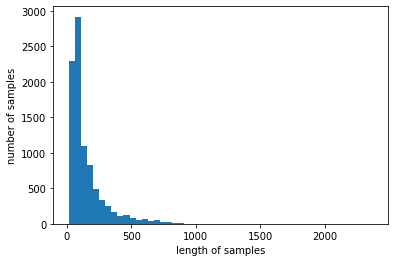

In [9]:
# 데이터 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

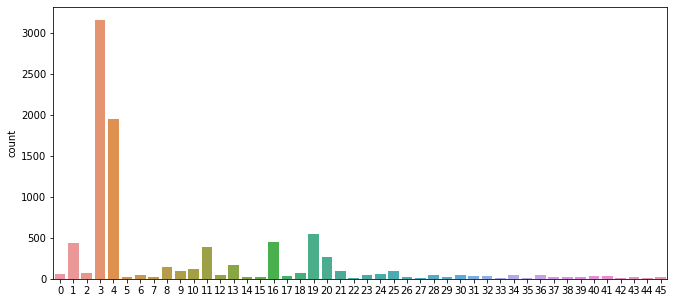

In [10]:
# 클래스 분포 확인 - 그래프
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

- 데이터 불균형이란 어떤 데이터에서 각 클래스(주로 범주형 변수)가 갖고 있는 데이터의 양에 차이가 큰 경우입니다. 
- 위 reuter 클래스 빈도 그래프를 살펴보면, 총 46개의 클래스 중에서, 클래스 3,4의 빈도는 3000이 넘고 그 다음으로 빈도가 높은 19,1,11,16의 경우 약 500의 빈도를 보입니다. 그 외의 클래스들의 빈도는 200 미만으로, 데이터의 큰 불균형을 확인할 수 있습니다.  
- 따라서 성능평가 시, 데이터 불균형을 고려하지 않으면 정확한 평가가 불가능할 것으로 보입니다.
- 데이터가 불균형한 경우, accuracy값은 편향의 함정에 빠지게 될 수 있습니다.
- F1 score는 불균형 분류문제에서 평가척도로 주로 사용됩니다. 

### classification_report
- scikitlearn의 metrics 패키지에서는 정밀도, 재현율, F1 점수를 구하는 classification_report를 제공합니다. 
- 정확도(accuracy) : 전체 샘플 중 맞게 예측한 샘플 수의 비율으로, 높을 수록 좋은 모형입니다. 

$$accuracy= {𝑇𝑃+𝑇𝑁 \over 𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁}$$

- 정밀도(precision) : 양성(positive) 클래스에 속한다고 출력한 샘플 중 실제도 양성 클래스에 속하는 샘플 수의 비율으로, 높을 수록 좋은 모형입니다. 

$$precision={𝑇𝑃 \over 𝑇𝑃+𝐹𝑃}$$

- 재현률(recall) : 실제 양성 클래스에 속한 표본 중에 양성 클래스에 속한다고 출력한 표본의 수의 비율로, 높을 수록 좋은 모형입니다.

$$recall={𝑇𝑃 \over 𝑇𝑃+𝐹𝑁}$$

- 위양성율(fallout) : 실제 양성 클래스에 속하지 않는 표본 중에 양성 클래스에 속한다고 출력한 표본의 비율로, 낮을수록 좋은 모형입니다.

$$fallout={𝐹𝑃 \over 𝐹𝑃+𝑇𝑁}$$

- F점수(F-score) : 정밀도와 재현율의 가중조화평균(weight harmonic average)입니다. 정밀도에 주어지는 가중치를 beta라고 할 때, beta가 1인경우를 특별히 F1점수라고 합니다. 

$$𝐹𝛽={(1+𝛽^2)(precision×recall) \over (𝛽^2precision+recall)}$$
$$𝐹1={2⋅precision⋅recall \over (precision+recall)}$$

    - F1 score는 Sensitivity와 Precision의 값이 서로다른 형태를 나타내는 불균형 상태이지만, 이를 조화평균함으로써, 큰 값의 크기에 대한 가중치를 낮추고, 작은 값에 더 맞춰주는 과정을 거쳐서 값의 크기 차이를 어느정도 상쇄하게 됩니다. 
    - 예를들어, input class가 Positive에 맞춰져 있어, 모델이 긍정에 대한 예측이 강한 분류기로 만들어졌다고 할때, F1 Score 평가척도를 구해서 올바르게 분류가 되었는지 성능을 측정할 수 있는 것입니다. 
    
---

- micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
    -  각 클래스에 대한 TP/FP/FN을 합한 뒤에 f1-score를 계산합니다. 
- macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    - 각 클래스에 따라 TP,FN,FP,TN값들을 이용해서 평가지표를 계산한 뒤 극 값들의 평균을 사용합니다. 
    - 각 레이블의 unweighted된 평균(레이블이 불균형한 멀티-클래스 분류 문제에서)을 계산합니다. 즉레이블의 불균형을 고려하지 않습니다.
    - 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가합니다. 따라서 가장 빈도 높은 클래스 레이블의 성능이 중요합니다.
- weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    - 각 클래스에 해당하는 데이터 개수에 가중치를 두어 평균을 구합니다. 
    - 각 클래스에 대한 f1-score를 계산한 뒤 각 클래스 별 데이터 비율에 따른 가중 평균을 내어 f1-score를 계산합니다. 
    - 각 레이블이 불균형해도, weight를 주어 평가지표를 계산합니다.
- samples: Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score.
    
    - 각 레이블의 평가지표를 평균 냅니다.

In [11]:
# 클래스 분포 확인 - 수치
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 1.2 데이터 복원하기

정수 시퀀스로 변환된 데이터를 원본 뉴스 데이터인 텍스트로 돌려봅니다.

In [12]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

- 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공합니다. reuters.get_word_index()에서 얻는 숫자보다 +3을 해야 실제 맵핑되는 정수입니다. 이건 로이터 뉴스 데이터가 정의한 일종의 약속입니다.
- tf.keras.datasets.reuters.get_word_index() : Retrieves a dict mapping words to their index in the Reuters dataset    
    https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/get_word_index
  

In [13]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [14]:
# 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- 잘 복원된 것을 확인할 수 있습니다.

이제 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해 봅니다.

In [15]:
# 데이터 복원 
def convert2text(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)

    return decoded

In [16]:
# train 데이터 복원 
x_train = convert2text(x_train)
print(len(x_train))

8982


In [17]:
# test 데이터 복원 
x_test = convert2text(x_test)
print(len(x_test))

2246


In [18]:
x_train[:2]

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3"]

In [19]:
x_test[:2]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

- 제대로 변환이 되었는지 확인할 수 있습니다. 

## 1.3 벡터화 하기

텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 벡터화 방법은 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬을 사용합니다. 
- DTM은 사이킷런의 CountVectorizer()를 통해서 생성할 수 있습니다.
- TF-IDF Matrix는 사이킷런의 TfidfTransformer()를 통해서 생성할 수 있습니다. 

In [20]:
# DTM 생성 
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [21]:
# TF-IDF 행렬 생성 
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


테스트 데이터에 대한 정확도를 측정하기 위해서는 테스트 데이터도 훈련 데이터와 동일한 전처리를 거쳐야 합니다. 

In [22]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
print(x_test_dtm.shape)
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print(tfidfv_test.shape)

(2246, 26506)
(2246, 26506)


## 1.4 머신러닝 모델 적용 

### 1) 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용할 수 있습니다.

In [23]:
mnb = MultinomialNB()
mnb.fit(tfidfv, y_train)

MultinomialNB()

In [24]:
predicted = mnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


### 2) Complement Naive Bayes Classifier(CNB)

In [25]:
cnb = ComplementNB()
cnb.fit(tfidfv, y_train)

ComplementNB()

In [26]:
predicted = cnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


### 3) 로지스틱 회귀(Logistic Regression)

In [27]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000)

In [28]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


### 4) 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [29]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [30]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7813891362422084


### 5) 결정 트리(Decision Tree)

In [31]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [32]:
predicted = dtree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


### 6) 랜덤 포레스트(Random Forest)

In [33]:
rdforest = RandomForestClassifier(n_estimators=5, random_state=0)
rdforest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [34]:
predicted = rdforest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


### 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [35]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [36]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.769813000890472


### 8) 보팅(Voting)

In [37]:
vt_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
vt_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [38]:
predicted = vt_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


# 2. 빈도수 상위 5,000개의 단어만 사용

(x_train, y_train), (x_test, y_test) = reuters.load_data(**num_words=5000**, test_split=0.2)

## 2.1 데이터 로드하기

In [39]:
(x_train2, y_train2), (x_test2, y_test2) = reuters.load_data(num_words=5000, test_split=0.2)

## 2.2 데이터 복원하기

In [40]:
len(index_to_word)

30982

In [41]:
# train 데이터 복원 
x_train2 = convert2text(x_train2)
print(len(x_train2))

8982


In [42]:
# test 데이터 복원 
x_test2 = convert2text(x_test2)
print(len(x_test2))

2246


## 2.3 벡터화 하기

In [43]:
## train data 
# DTM 생성 
#dtmvector = CountVectorizer()
x_train2_dtm = dtmvector.fit_transform(x_train2)
print(x_train2_dtm.shape)

# TF-IDF 행렬 생성 
#tfidf_transformer = TfidfTransformer()
tfidfv2 = tfidf_transformer.fit_transform(x_train2_dtm)
print(tfidfv2.shape)

(8982, 4867)
(8982, 4867)


In [44]:
## test data 
# DTM으로 변환
x_test2_dtm = dtmvector.transform(x_test2) 
print(x_test2_dtm.shape)

# DTM을 TF-IDF 행렬로 변환
tfidfv_test2 = tfidf_transformer.transform(x_test2_dtm) 
print(tfidfv_test2.shape)

(2246, 4867)
(2246, 4867)


## 2.4 머신러닝 모델 적용

### 1) 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

In [45]:
#mnb = MultinomialNB()
mnb.fit(tfidfv2, y_train2)
predicted = mnb.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


### 2) Complement Naive Bayes Classifier(CNB)

In [46]:
#cnb = ComplementNB()
cnb.fit(tfidfv2, y_train2)
predicted = cnb.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 3) 로지스틱 회귀(Logistic Regression)

In [47]:
#lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv2, y_train2)
predicted = lr.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4) 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [48]:
#lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv2, y_train2)
predicted = lsvc.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.7662511130899377


C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 5) 결정 트리(Decision Tree)

In [49]:
#dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree.fit(tfidfv2, y_train2)
predicted = dtree.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


### 6) 랜덤 포레스트(Random Forest)


In [50]:
#rdforest = RandomForestClassifier(n_estimators=5, random_state=0)
rdforest.fit(tfidfv2, y_train2)
predicted = rdforest.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


### 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [51]:
#grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv2, y_train2)
predicted = grbt.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.7671415850400712


### 8) 보팅(Voting)

In [52]:
#vt_classifier = VotingClassifier(estimators=[
#         ('lr', LogisticRegression(C=10000, penalty='l2')),
#        ('cb', ComplementNB()),
#        ('grbt', GradientBoostingClassifier(random_state=0))
#], voting='soft', n_jobs=-1)
vt_classifier.fit(tfidfv2, y_train2)
predicted = vt_classifier.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.8161175422974176


# 3. 빈도수 상위 15,000개의 단어만 사용

(x_train, y_train), (x_test, y_test) = reuters.load_data(**num_words=15000**, test_split=0.2)

## 3.1 데이터 로드하기

In [53]:
(x_train3, y_train3), (x_test3, y_test3) = reuters.load_data(num_words=15000, test_split=0.2)

## 3.2 데이터 복원하기

In [54]:
len(index_to_word)

30982

In [55]:
# train 데이터 복원 
x_train3 = convert2text(x_train3)
print(len(x_train3))

8982


In [56]:
# test 데이터 복원 
x_test3 = convert2text(x_test3)
print(len(x_test3))

2246


## 3.3 벡터화 하기

In [57]:
## train data 
# DTM 생성 
#dtmvector = CountVectorizer()
x_train3_dtm = dtmvector.fit_transform(x_train3)
print(x_train3_dtm.shape)

# TF-IDF 행렬 생성 
#tfidf_transformer = TfidfTransformer()
tfidfv3 = tfidf_transformer.fit_transform(x_train3_dtm)
print(tfidfv3.shape)

(8982, 14227)
(8982, 14227)


In [58]:
## test data 
# DTM으로 변환
x_test3_dtm = dtmvector.transform(x_test3) 
print(x_test3_dtm.shape)

# DTM을 TF-IDF 행렬로 변환
tfidfv_test3 = tfidf_transformer.transform(x_test3_dtm) 
print(tfidfv_test3.shape)

(2246, 14227)
(2246, 14227)


## 3.4 머신러닝 모델 적용

### 1) 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

In [59]:
#mnb = MultinomialNB()
mnb.fit(tfidfv3, y_train3)
predicted = mnb.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.6331255565449688


### 2) Complement Naive Bayes Classifier(CNB)

In [60]:
#cnb = ComplementNB()
cnb.fit(tfidfv3, y_train3)
predicted = cnb.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.7720391807658059


### 3) 로지스틱 회귀(Logistic Regression)

In [61]:
#lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv3, y_train3)
predicted = lr.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.8125556544968834


C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4) 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [62]:
#lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv3, y_train3)
predicted = lsvc.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.7813891362422084


C:\Users\Noah\anaconda3\envs\Aiffel2\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 5) 결정 트리(Decision Tree)

In [63]:
#dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree.fit(tfidfv3, y_train3)
predicted = dtree.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.6193232413178985


### 6) 랜덤 포레스트(Random Forest)

In [64]:
#rdforest = RandomForestClassifier(n_estimators=5, random_state=0)
rdforest.fit(tfidfv3, y_train3)
predicted = rdforest.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.6714158504007124


### 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [65]:
#grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv3, y_train3)
predicted = grbt.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 8) 보팅(Voting)

In [66]:
#vt_classifier = VotingClassifier(estimators=[
#         ('lr', LogisticRegression(C=10000, penalty='l2')),
#        ('cb', ComplementNB()),
#        ('grbt', GradientBoostingClassifier(random_state=0))
#], voting='soft', n_jobs=-1)
vt_classifier.fit(tfidfv3, y_train3)
predicted = vt_classifier.predict(tfidfv_test3) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test3, predicted)) #예측값과 실제값 비교

정확도: 0.8165627782724845


[accuracy]

|num_words=|None|5000|10000|15000|
|------:|:---:|:---:|:---:|:---:|
|Multinomial Naive Bayes Classifier | 0.5997328584149599 | 0.6731967943009796 | 0.6567230632235085 | 0.6331255565449688|
|Complement Naive Bayes Classifier|0.7649154051647373|0.7707034728406055|0.7707034728406055| 0.7720391807658059|
|Logistic Regression|0.813446126447017|0.8058771148708815|0.8076580587711487| 0.8125556544968834|
|Linear Support Vector Machine|0.7867319679430098|0.763579697239537|0.7804986642920748| 0.7813891362422084|
|Decision Tree|0.6211041852181657|0.6179875333926982|0.6202137132680321| 0.6193232413178985|
|Random Forest|0.6544968833481746|0.701246660730187|0.674087266251113| 0.6714158504007124|
|Gradient Boosting Classifier|0.7702582368655387|0.767586821015138|0.7666963490650045| 0.7707034728406055|
|Voting|0.8187889581478184|0.8161175422974176|0.8116651825467498| 0.8165627782724845|

대체적으로 성능이 좋은 num_words=15000 으로 딥러닝 모델과 비교해 봅니다. 

# 4. 딥러닝 모델과 비교해 보기

- 참고 : 로이터 뉴스 분류하기 https://wikidocs.net/22933

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [68]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

In [69]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [70]:
print(X_train.shape, y_train.shape)

(8982,) (8982, 46)


In [71]:
X_train = pad_sequences(X_train, padding='pre')
X_test = pad_sequences(X_test, padding='pre')

In [72]:
vocab_size = 15000

rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, 128))
rnn_model.add(LSTM(128))
rnn_model.add(Dense(46, activation='softmax'))

In [73]:
# 모델 학습
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=50)

Epoch 1/50
71/71 [==============================] - 13s 138ms/step - loss: 2.6293 - acc: 0.3456
Epoch 2/50
71/71 [==============================] - 9s 133ms/step - loss: 2.1323 - acc: 0.4431
Epoch 3/50
71/71 [==============================] - 9s 133ms/step - loss: 1.8014 - acc: 0.5239
Epoch 4/50
71/71 [==============================] - 9s 133ms/step - loss: 1.7105 - acc: 0.5529
Epoch 5/50
71/71 [==============================] - 10s 134ms/step - loss: 1.5729 - acc: 0.5944
Epoch 6/50
71/71 [==============================] - 9s 133ms/step - loss: 1.4964 - acc: 0.6147
Epoch 7/50
71/71 [==============================] - 10s 134ms/step - loss: 1.3825 - acc: 0.6505
Epoch 8/50
71/71 [==============================] - 9s 133ms/step - loss: 1.4381 - acc: 0.6124
Epoch 9/50
71/71 [==============================] - 9s 132ms/step - loss: 1.1902 - acc: 0.6983
Epoch 10/50
71/71 [==============================] - 9s 133ms/step - loss: 0.9798 - acc: 0.7574
Epoch 11/50
71/71 [===========================

In [74]:
# 모델 평가
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)
print(rnn_results)

71/71 - 2s - loss: 2.3037 - acc: 0.6505 - 2s/epoch - 28ms/step
[2.3037171363830566, 0.6504897475242615]


- RNN 모델이 69% 정도의 accuracy인 것을 볼 수 있다. 

In [75]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 5090초입니다.


# 회고 

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
    - 3가지 단어 개수(None, 5000, 15000)에 대해 8가지 머신러닝 기법을 적용해 보았다. 
    - 그중 최적의 솔루션을 15000으로 도출하였으나 도출하는 방법의 지표를 accuracy만으로 판단하였다. 


2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
    - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살펴보았지만 해당 머신러닝 알고리즘의 특성을 잘 파악하지 못해서인지 모델의 성능이 일정하지 않음에 대해 다시 공부해야 할 것 같다. 
    - 성능 지표를 F1 score가 아닌 accuracy만으로 판단하였다. F1 score에 대한 추가적인 공부를 해야할 것 같다. 
    

3. 딥러닝 모델(RNN)을 활용해 성능이 비교 및 확인되었는가?
    - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하였다. 
    - 하지만 RNN 모델에서 validation set을 사용하지 못하고 epoch=50 으로만 돌려서 인지 성능이 그리 좋지는 않았다. 